In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [71]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_and_location.csv'

In [72]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc

ax                 ay                 az  \
11:05:09:00 0.917251600000000  0.223266600000000  9.617767000000001   
11:05:09:01 0.799926760000000  0.194534300000000  9.680023000000000   
11:05:09:02 0.658676150000000  0.101165770000000  9.876343000000000   
11:05:09:03 0.594024660000000  0.072433470000000 10.029572000000000   
11:05:09:04 0.634735100000000  0.041305542000000 10.098998999999999   
...                       ...                ...                ...   
19:09:27:16 1.302719100000000  0.520156860000000  7.142166000000000   
19:09:27:17 2.049713100000000  0.280731200000000  8.202788999999999   
19:09:27:18 2.140686000000000  0.043701172000000  9.170044000000001   
19:09:27:19 1.896484400000000 -0.226837160000000  9.799728000000000   
19:09:27:20 1.659454300000000 -0.241210940000000  9.857193000000001   

                            gx                 gy                 gz  \
11:05:09:00 -0.033401490000000  0.057952880000000  0.003723144500000   
11:05:09:01 -0.052566530000000  0.046249390000000 -0.004806518600000   
11:05:09:02 -0.057891846000000  0.024932861000000 -0.003738403300000   
11:05:09:03 -0.036590576000000  0.002563476600000  0.007980347000000   
11:05:09:04 -0.012084961000000 -0.029388428000000  0.015441894500000   
...                        ...                ...                ...   
19:09:27:16 -0.118621826000000 -0.505569460000000  0.092132570000000   
19:09:27:17 -0.301849370000000 -0.332992550000000  0.140075680000000   
19:09:27:18 -0.590530400000000  0.304031370000000  0.046325684000000   
19:09:27:19 -0.686401370000000  0.651306150000000 -0.067657470000000   
19:09:27:20 -0.760971070000000  0.844131470000000 -0.144348140000000   

                            mx                  my                   mz  \
11:05:09:00 51.450348499999997 -49.124908499999997 -263.400264999999990   
11:05:09:01 52.200316999999998 -48.599243000000001 -263.549800000000005   
11:05:09:02 52.349853500000002 -49.124908499999997 -263.175200000000018   
11:05:09:03 52.499389999999998 -49.650573999999999 -262.800599999999974   
11:05:09:04 50.999450000000003 -50.025176999999999 -262.274935000000028   
...                        ...                 ...                  ...   
19:09:27:16 22.650145999999999 -15.150451500000001 -262.875364999999988   
19:09:27:17 23.100280000000001 -16.200256000000000 -262.800599999999974   
19:09:27:18 23.100280000000001 -13.949585000000001 -261.749270000000024   
19:09:27:19 24.050394333333333 -13.749694999999999 -262.549340000000029   
19:09:27:20 25.000508666666668 -13.549804999999999 -263.349409999999978   

                       a_total           g_total             m_total  \
11:05:09:00  9.663986782827630 0.066992967089706 272.838632163932175   
11:05:09:01  9.714966376461094 0.070180829096450 273.029772360293236   
11:05:09:02  9.898799919043093 0.063143400685792 272.791737487752755   
11:05:09:03 10.047408939992856 0.037538348425722 272.553702615212273   
11:05:09:04 10.119010603659476 0.035329563943415 271.834052942028165   
...                        ...               ...                 ...   
19:09:27:16  7.278610814164050 0.527408785424618 264.286459212824525   
19:09:27:17  8.459662001373697 0.470763503951147 264.310852200404213   
19:09:27:18  9.416695455676912 0.665813259304968 263.136645496752351   
19:09:27:19  9.984126253738191 0.948643281224560 264.009983987171552   
19:09:27:20  9.998811185866709 1.145631395145387 264.883322477590696   

                           lat               long  
11:05:09:00 44.434918000000003 26.047605999999998  
11:05:09:01 44.434918000000003 26.047606078717038  
11:05:09:02 44.434918000000003 26.047606157434078  
11:05:09:03 44.434917999999989 26.047606236151118  
11:05:09:04 44.434917999999989 26.047606314868165  
...                        ...                ...  
19:09:27:16 44.434937499964583 26.047601919741037  
19:09:27:17 44.434937499964576 26.047601814784940  
19:09:27:18 44.434937499964576 26.047601709828850  
19:09:27:19 44.43493749

In [217]:
data = df_sensor_and_loc.copy(deep=True)[::1]
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
data.head()

ax                ay                 az                 gx  \
0 0.917251600000000 0.223266600000000  9.617767000000001 -0.033401490000000   
1 0.799926760000000 0.194534300000000  9.680023000000000 -0.052566530000000   
2 0.658676150000000 0.101165770000000  9.876343000000000 -0.057891846000000   
3 0.594024660000000 0.072433470000000 10.029572000000000 -0.036590576000000   
4 0.634735100000000 0.041305542000000 10.098998999999999 -0.012084961000000   

                  gy                 gz                 mx  \
0  0.057952880000000  0.003723144500000 51.450348499999997   
1  0.046249390000000 -0.004806518600000 52.200316999999998   
2  0.024932861000000 -0.003738403300000 52.349853500000002   
3  0.002563476600000  0.007980347000000 52.499389999999998   
4 -0.029388428000000  0.015441894500000 50.999450000000003   

                   my                   mz            a_total  \
0 -49.124908499999997 -263.400264999999990  9.663986782827630   
1 -48.599243000000001 -263.549800000000005  9.714966376461094   
2 -49.124908499999997 -263.175200000000018  9.898799919043093   
3 -49.650573999999999 -262.800599999999974 10.047408939992856   
4 -50.025176999999999 -262.274935000000028 10.119010603659476   

            g_total             m_total                lat               long  
0 0.066992967089706 272.838632163932175 44.434918000000003 26.047605999999998  
1 0.070180829096450 273.029772360293236 44.434918000000003 26.047606078717038  
2 0.063143400685792 272.791737487752755 44.434918000000003 26.047606157434078  
3 0.037538348425722 272.553702615212273 44.434917999999989 26.047606236151118  
4 0.035329563943415 271.834052942028165 44.434917999999989 26.047606314868165

# 2. View some info about the data

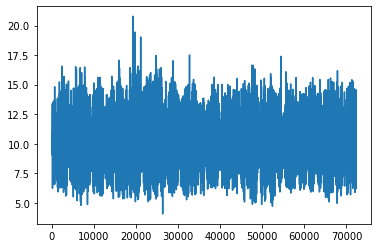

In [218]:
plt.plot(data['a_total'])

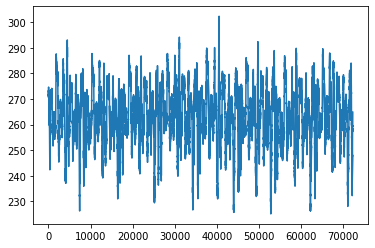

In [219]:
plt.plot(data['m_total'])

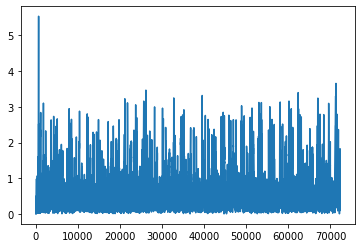

In [220]:
plt.plot(data['g_total'])

### Plot a simple Latitude and Longitude scatter plot

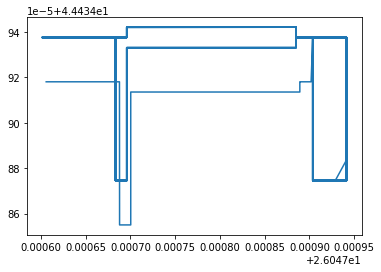

In [221]:
plt.plot(data['long'], data['lat'])

### Plot the Latitude and Longitude on the world map

In [222]:
import plotly.express as px
import pandas as pd

pos_df = pd.concat([data['lat'], data['long']], axis=1)
fig = px.scatter_geo(pos_df,lat=pos_df['lat'],lon=pos_df['long'], hover_name=pos_df.index)
fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=pos_df['lat'][0], lon=pos_df['long'][0])))
fig.show()

### Plot the ground truth from xml in order to compare with the interpolated data

In [223]:
position_file = '../data/Processed/partial_4_ground_truth.csv'
position_df = pd.read_csv(position_file, index_col=0)
position_df

lat               long
11:05:09:00 44.434918000000003 26.047605999999998
11:05:10:60 44.434917999999307 26.047618594726657
11:05:11:60 44.434917999998618 26.047631189453320
11:05:12:40 44.434917999997921 26.047643784179972
11:05:13:20 44.434917999997225 26.047656378906638
...                        ...                ...
13:04:50:40 44.434937499967326 26.047651878840107
13:04:51:20 44.434937499966637 26.047639284109248
13:04:52:20 44.434937499965947 26.047626689378390
13:04:53:20 44.434937499965251 26.047614094647528
13:04:54:20 44.434937499964562 26.047601499916670

[276 rows x 2 columns]

In [224]:
fig = px.scatter_geo(position_df,lat=position_df['lat'],lon=position_df['long'], hover_name=position_df.index)
fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=position_df['lat'][0], lon=position_df['long'][0])))
fig.show()

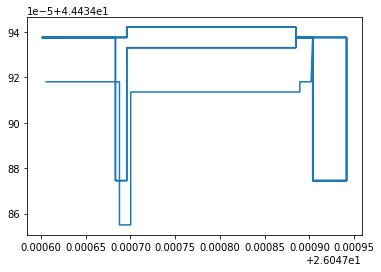

In [225]:
plt.plot(position_df['long'], position_df['lat'])

# 3. Creating the LSTM model

## 3.1. Scaling the data

In [226]:
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(data)
y_test_1 = data.iloc[:, [-2, -1]]
print(y_test_1)
y_test_sc = sc.fit_transform(data.iloc[:, [-2, -1]])
print(data_scaled)

                     lat               long
0     44.434918000000003 26.047605999999998
1     44.434918000000003 26.047606078717038
2     44.434918000000003 26.047606157434078
3     44.434917999999989 26.047606236151118
4     44.434917999999989 26.047606314868165
...                  ...                ...
72313 44.434937499964583 26.047601919741037
72314 44.434937499964576 26.047601814784940
72315 44.434937499964576 26.047601709828850
72316 44.434937499964569 26.047601604872760
72317 44.434937499964562 26.047601499916670

[72318 rows x 2 columns]
[[5.16042093e-01 4.74944841e-01 3.38306942e-01 ... 6.17874252e-01
  7.24015708e-01 1.32332916e-02]
 [5.06570933e-01 4.72011381e-01 3.42037621e-01 ... 6.20350631e-01
  7.24015708e-01 1.34647730e-02]
 [4.95168341e-01 4.62478803e-01 3.53802062e-01 ... 6.17266692e-01
  7.24015708e-01 1.36962543e-02]
 ...
 [6.14805012e-01 4.56611882e-01 3.11477221e-01 ... 4.92176969e-01
  9.48284431e-01 6.17283920e-04]
 [5.95091603e-01 4.28990929e-01 3.49210922e-0

In [227]:
print(data_scaled.shape[0], data_scaled.shape[1])

72318 14


## 3.2. Reshaping the data in order to feed it to the model

In [228]:
# The following cell does this:

# []
# i = 0
# X = [[]]
# for j in range(30, 8611)
#     J = 30
#     X[0].append(data_scaled[30-30=0:30, 0]) --> append and array
#     J = 31
#     X[0].append(31-30=1:31, 0)
#     
# i = 1
# X = [
#       [  <-- 12 of those
#        [5.5811, 5.4786, .., 5.1232  <--- 30 (backcandles) of those], [], ..., [] <--- 8581 of those
#       ],
#      [
#        [5.5811, 5.4786, .., 5.1232], [], ..., []
#      ]
#    ]   ---> 
# for j in range(30, 8611)
#     X[0].append(data_scaled[30-30:30, 0])

In [229]:
X = []
backcandles=50 # number of last values to look into

for i in range(12): #number of attributes columns
    X.append([])
    for j in range(backcandles, data_scaled.shape[0]):
        X[i].append(data_scaled[j-backcandles:j, i])
        
# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# We need shape (8581, 30, 12) = (rows, val of past attributes, columns) for LSTM training
X.shape

(72268, 50, 12)

In [230]:
# Transform X and the targets (lat and long columns) into arrays so the axis can be moved and the data 
# to be used in the LSTM model
X, y = np.array(X), np.array(data_scaled[backcandles:, [-2,-1]])

# Move the axis for yi, so instead of (8581, 2) we'll have (8581, 1, 2)
# I HAVE MODIFIED THIS:
# y = np.reshape(yi,(len(yi), 1, 2))
# y = np.reshape(yi,(len(yi), 2))

print('X Shape: ',X.shape)
print('y shape: ', y.shape)
data_scaled[backcandles:, [-2,-1]]

X Shape:  (72268, 50, 12)
y shape:  (72268, 2)


array([[7.24015706e-01, 2.48073613e-02],
       [7.24015706e-01, 2.50388427e-02],
       [7.24015706e-01, 2.52703241e-02],
       ...,
       [9.48284431e-01, 6.17283920e-04],
       [9.48284431e-01, 3.08641960e-04],
       [9.48284431e-01, 0.00000000e+00]])

## 3.3. Split the data into train, test and validation sets

In [231]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

50587 65041
(50587, 50, 12)
(14454, 50, 12)
(7227, 50, 12)
(50587, 2)
(14454, 2)
(7227, 2)


## 3.4. Creating the LSTM  model

In [ ]:
attributes_cols = 12
batch_size=100
epochs=100

lstm_input = Input(shape=(backcandles, attributes_cols), name='lstm_input')
inputs = LSTM(128, name='first_layer')(lstm_input)
inputs = Dense(2, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, epochs=epochs, shuffle=False, validation_data=(X_val, y_val))

Epoch 1/100
1581/1581 [==============================] - 76s 46ms/step - loss: 0.0180 - accuracy: 0.8864 - val_loss: 0.3279 - val_accuracy: 0.2475
Epoch 2/100
1581/1581 [==============================] - 58s 37ms/step - loss: 0.0395 - accuracy: 0.8090 - val_loss: 0.1194 - val_accuracy: 0.2475
Epoch 3/100
1581/1581 [==============================] - 66s 42ms/step - loss: 0.0486 - accuracy: 0.7838 - val_loss: 0.1002 - val_accuracy: 0.2475
Epoch 4/100
1581/1581 [==============================] - 50s 32ms/step - loss: 0.0503 - accuracy: 0.7826 - val_loss: 0.0980 - val_accuracy: 0.2927
Epoch 5/100
1581/1581 [==============================] - 49s 31ms/step - loss: 0.0565 - accuracy: 0.7642 - val_loss: 0.0880 - val_accuracy: 0.4696
Epoch 6/100
1581/1581 [==============================] - 50s 31ms/step - loss: 0.0629 - accuracy: 0.7519 - val_loss: 0.0777 - val_accuracy: 0.5648
Epoch 7/100
1581/1581 [==============================] - 50s 32ms/step - loss: 0.0663 - accuracy: 0.7386 - val_loss: 0

1581/1581 [==============================] - 52s 33ms/step - loss: 0.0663 - accuracy: 0.8204 - val_loss: 0.0600 - val_accuracy: 0.7988
Epoch 57/100
1581/1581 [==============================] - 52s 33ms/step - loss: 0.0660 - accuracy: 0.8210 - val_loss: 0.0596 - val_accuracy: 0.7991
Epoch 58/100
1581/1581 [==============================] - 51s 32ms/step - loss: 0.0657 - accuracy: 0.8219 - val_loss: 0.0593 - val_accuracy: 0.7994
Epoch 59/100
1581/1581 [==============================] - 51s 32ms/step - loss: 0.0655 - accuracy: 0.8223 - val_loss: 0.0587 - val_accuracy: 0.8013
Epoch 60/100
1581/1581 [==============================] - 50s 32ms/step - loss: 0.0652 - accuracy: 0.8229 - val_loss: 0.0583 - val_accuracy: 0.8020
Epoch 61/100
1581/1581 [==============================] - 51s 32ms/step - loss: 0.0650 - accuracy: 0.8231 - val_loss: 0.0580 - val_accuracy: 0.8028
Epoch 62/100
1581/1581 [==============================] - 51s 33ms/step - loss: 0.0647 - accuracy: 0.8239 - val_loss: 0.0577 

In [ ]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

In [ ]:
plt.plot(y_test[:, 0], color='black', label='Test')
plt.plot(y_pred[:, 0], color='blue', label='Pred')
y_test[:, 0]

In [ ]:
# data = {'c1': [2, 3, 4], 'c2': [3, 5, 6], 'c3': [3, 5, 6]}
# df = pd.DataFrame(data)
# df
# print(df.iloc[:, [-2, -1]])

In [ ]:
y_test_descaled = sc.inverse_transform(y_test_sc)
y_pred_scaled = sc.inverse_transform(y_pred)
# lat1 = 
plt.plot(y_test_descaled[:, 1], y_test_descaled[:, 0], color='black', label='Test')
plt.plot(y_pred_scaled[:, 1], y_pred_scaled[:, 0], color='blue', label='Pred')
# y_test_descaled[:, 0]
# y_test_descaled[:, 1]

In [ ]:
model.evaluate(X_test, y_test)